<a href="https://colab.research.google.com/github/CastHash532/flaml-automl/blob/main/Notebooks/Kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

AutoML with FLAML Library


## Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

     |████████████████████████████████| 155 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 40.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 67.4 MB 31 kB/s 
     |████████████████████████████████| 12.4 MB 175 kB/s 
     |████████████████████████████████| 757 kB 45.9 MB/s 
     |████████████████████████████████| 158 kB 49.8 MB/s 
  Created wheel for openml: filename=openml-0.10.2-py3-none-any.whl size=190318 sha256=4eac34466739bd45d8fa9a1f00854dfc39f8876ee5dda765b82172f60425378a
  Stored in directory: /root/.cache/pip/wheels/9c/9e/f3/6a5ebf16527d7fe22d9bc1652bc9beb5dc9fcfdeb75e805400
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11731 sha256=61b3c09ca50f1a33c594d1da5fb86ad91149119fd19d6bee43ac11d1fd373ec2
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff
  Attempting uninstall: scikit-learn
 

## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


## 2. Classification Example
### Load data and preprocess



In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 43.7MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 53.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.07MB/s]


In [ ]:
!ls

 gender_submission.csv	   nyc-traffic-accidents.zip   test.csv
'NYC Accidents 2020.csv'   sample_data		       train.csv


In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('train.csv')

In [ ]:
msk = np.random.rand(len(dataset)) < 0.8
ds_train = dataset[msk]
ds_test = dataset[~msk]

In [ ]:
X_train = ds_train.drop('Survived', axis=1)
y_train = ds_train['Survived']
X_test = ds_test.drop('Survived', axis=1)
y_test = ds_test['Survived']

### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [ ]:
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 09-18 22:23:44] {1427} INFO - Evaluation method: cv
[flaml.automl: 09-18 22:23:44] {1473} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-18 22:23:44] {1505} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 09-18 22:23:44] {1735} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-18 22:23:44] {1920} INFO -  at 0.3s,	best lgbm's error=0.2103,	best lgbm's error=0.2103
[flaml.automl: 09-18 22:23:44] {1735} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-18 22:23:44] {1920} INFO -  at 0.5s,	best lgbm's error=0.2103,	best lgbm's error=0.2103
[flaml.automl: 09-18 22:23:44] {1735} INFO - iteration 2, current learner lgbm
[flaml.automl: 09-18 22:23:44] {1920} INFO -  at 0.7s,	best lgbm's error=0.2103,	best lgbm's error=0.2103
[flaml.automl: 09-18 22:23:44] {1735} INFO - iteration 3, current learner xgboost
[flaml.automl: 09-18 22:23:44] {1920} INFO -  at 0.9s,	best xgboost's error

### Best model and metric

In [ ]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: catboost
Best hyperparmeter config: {'early_stopping_rounds': 10, 'learning_rate': 0.047337336217363433}
Best accuracy on validation data: 0.8356
Training duration of best run: 1.66 s


In [ ]:
automl.model.estimator

In [ ]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1
 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1
 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
True labels 3      1
6      0
17     1
22     1
31     1
      ..
864    0
869    1
874    1
885    0
889    1
Name: Survived, Length: 173, dtype: int64


In [ ]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))


accuracy = 0.815028901734104


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 718, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 718, 'Current Hyper-parameters': {'n_estimators': 7, 'num_leaves': 4, 'min_child_samples': 15, 'learning_rate': 0.2712162364070373, 'log_max_bin': 10, 'colsample_bytree': 0.9285002286474459, 'reg_alpha': 0.002668211515123386, 'reg_lambda': 0.5215467339232843}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 7, 'num_leaves': 4, 'min_child_samples': 15, 'learning_rate': 0.2712162364070373, 'log_max_bin': 10, 'colsample_bytree'

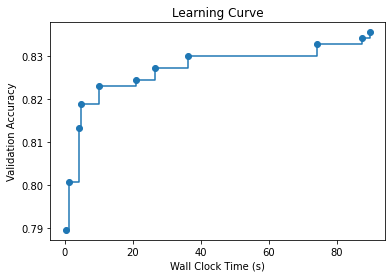

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()